In [2]:
import pandas as pd
import numpy as np

In [3]:
df_synthetic = pd.read_csv('/content/d_synthetic.csv')

In [ ]:
df_synthetic.head(1)

,RENDERING_NPI,POSTAL_CODE,DELIVERY_SYSTEM_ENCODED,PROVIDER_TYPE_ENCODED,AGE_GROUP_ENCODED,PREV,TXMT,ADV,CASE_ID,REQUIRED_SPEC,EXPEDITED,REQUIRED_LAB_TYPE,LAB_ID,LAB_POSTAL_CODE
0,1952483117,94538,0,0,0,1,0,0,1379044,1,0,0,488,94461


In [ ]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.1 MB/s eta 0:00:00


In [4]:
lab_counts = df_synthetic['LAB_ID'].value_counts()

lower_q = 0.25
upper_q = 0.75

MIN_COUNT_THRESHOLD = lab_counts.quantile(lower_q)
MAX_COUNT_THRESHOLD = lab_counts.quantile(upper_q)

valid_lab_ids = lab_counts[
    (lab_counts >= MIN_COUNT_THRESHOLD) & (lab_counts <= MAX_COUNT_THRESHOLD)
].index.tolist()

df_filtered = df_synthetic[
    df_synthetic['LAB_ID'].isin(valid_lab_ids)
].copy()

In [5]:
df_filtered['LAB_ID'].value_counts().describe()

,count
count,119.000000
mean,4951.134454
std,1781.051089
min,2520.000000
25%,3510.500000
50%,4515.000000
75%,6411.000000
max,8631.000000


getting new counts for CTGAN process

In [6]:
lab_counts = df_filtered['LAB_ID'].value_counts()

lower_q = 0.25

ct_min = lab_counts.quantile(lower_q)

ct_lab_ids = lab_counts[(lab_counts <= ct_min)].index.tolist()

ct_filtered = df_synthetic[
    df_synthetic['LAB_ID'].isin(ct_lab_ids)
].copy()

In [7]:
ct_filtered.head(1)

,RENDERING_NPI,POSTAL_CODE,DELIVERY_SYSTEM_ENCODED,PROVIDER_TYPE_ENCODED,AGE_GROUP_ENCODED,PREV,TXMT,ADV,CASE_ID,REQUIRED_SPEC,EXPEDITED,REQUIRED_LAB_TYPE,LAB_ID,LAB_POSTAL_CODE
24,1356762934,93550,0,0,0,0,1,0,516635,0,0,0,3007,93642


In [8]:
target_samples = ct_min - min(df_filtered['LAB_ID'].value_counts())
target_samples

np.float64(990.5)

In [ ]:
#@title CTGAN process - testing if this works
# import pandas as pd
# import numpy as np
# from sdv.single_table import CTGANSynthesizer
# from sdv.metadata import Metadata

# CTGAN_EPOCHS = 300

# def augment_data_with_ctgan(df_input, target_samples):

#     # --- 1. Define Corrected Metadata ---
#     metadata_val = {
#         # CRITICAL: Define the primary key as 'id'
#         'primary_key': 'CASE_ID',
#         'columns': {

#             'CASE_ID': {'sdtype': 'id'},
#             'RENDERING_NPI': {'sdtype': 'categorical'},
#             'POSTAL_CODE': {'sdtype': 'categorical'},
#             'LAB_POSTAL_CODE': {'sdtype': 'categorical'},


#             'LAB_ID': {'sdtype': 'categorical'},
#             'REQUIRED_SPEC': {'sdtype': 'categorical'},
#             'REQUIRED_LAB_TYPE': {'sdtype': 'categorical'},
#             'DELIVERY_SYSTEM_ENCODED': {'sdtype': 'categorical'},
#             'PROVIDER_TYPE_ENCODED': {'sdtype': 'categorical'},
#             'AGE_GROUP_ENCODED': {'sdtype': 'categorical'},

#             'PREV': {'sdtype': 'categorical'},
#             'TXMT': {'sdtype': 'categorical'},
#             'ADV': {'sdtype': 'categorical'},
#             'EXPEDITED': {'sdtype': 'categorical'},
#         }
#     }

#     for col in metadata_val['columns']:
#         if col in df_input.columns:
#             df_input[col] = df_input[col].astype(str)

#     # 3. Load Metadata Object (Corrected path)
#     metadata_object = Metadata.load_from_dict(metadata_val)

#     # 4. Initialize and Train the CT-GAN Model
#     synthesizer = CTGANSynthesizer(
#         metadata=metadata_object,
#         epochs=CTGAN_EPOCHS,
#         verbose=True
#     )

#     synthesizer.fit(df_input)
#     synthetic_data = synthesizer.sample(num_rows=target_samples)
#     synthetic_data['LAB_ID'] = pd.to_numeric(synthetic_data['LAB_ID'], errors='coerce').astype(int)

#     return synthetic_data

# df_synthetic_augmented = augment_data_with_ctgan(ct_filtered, target_samples)

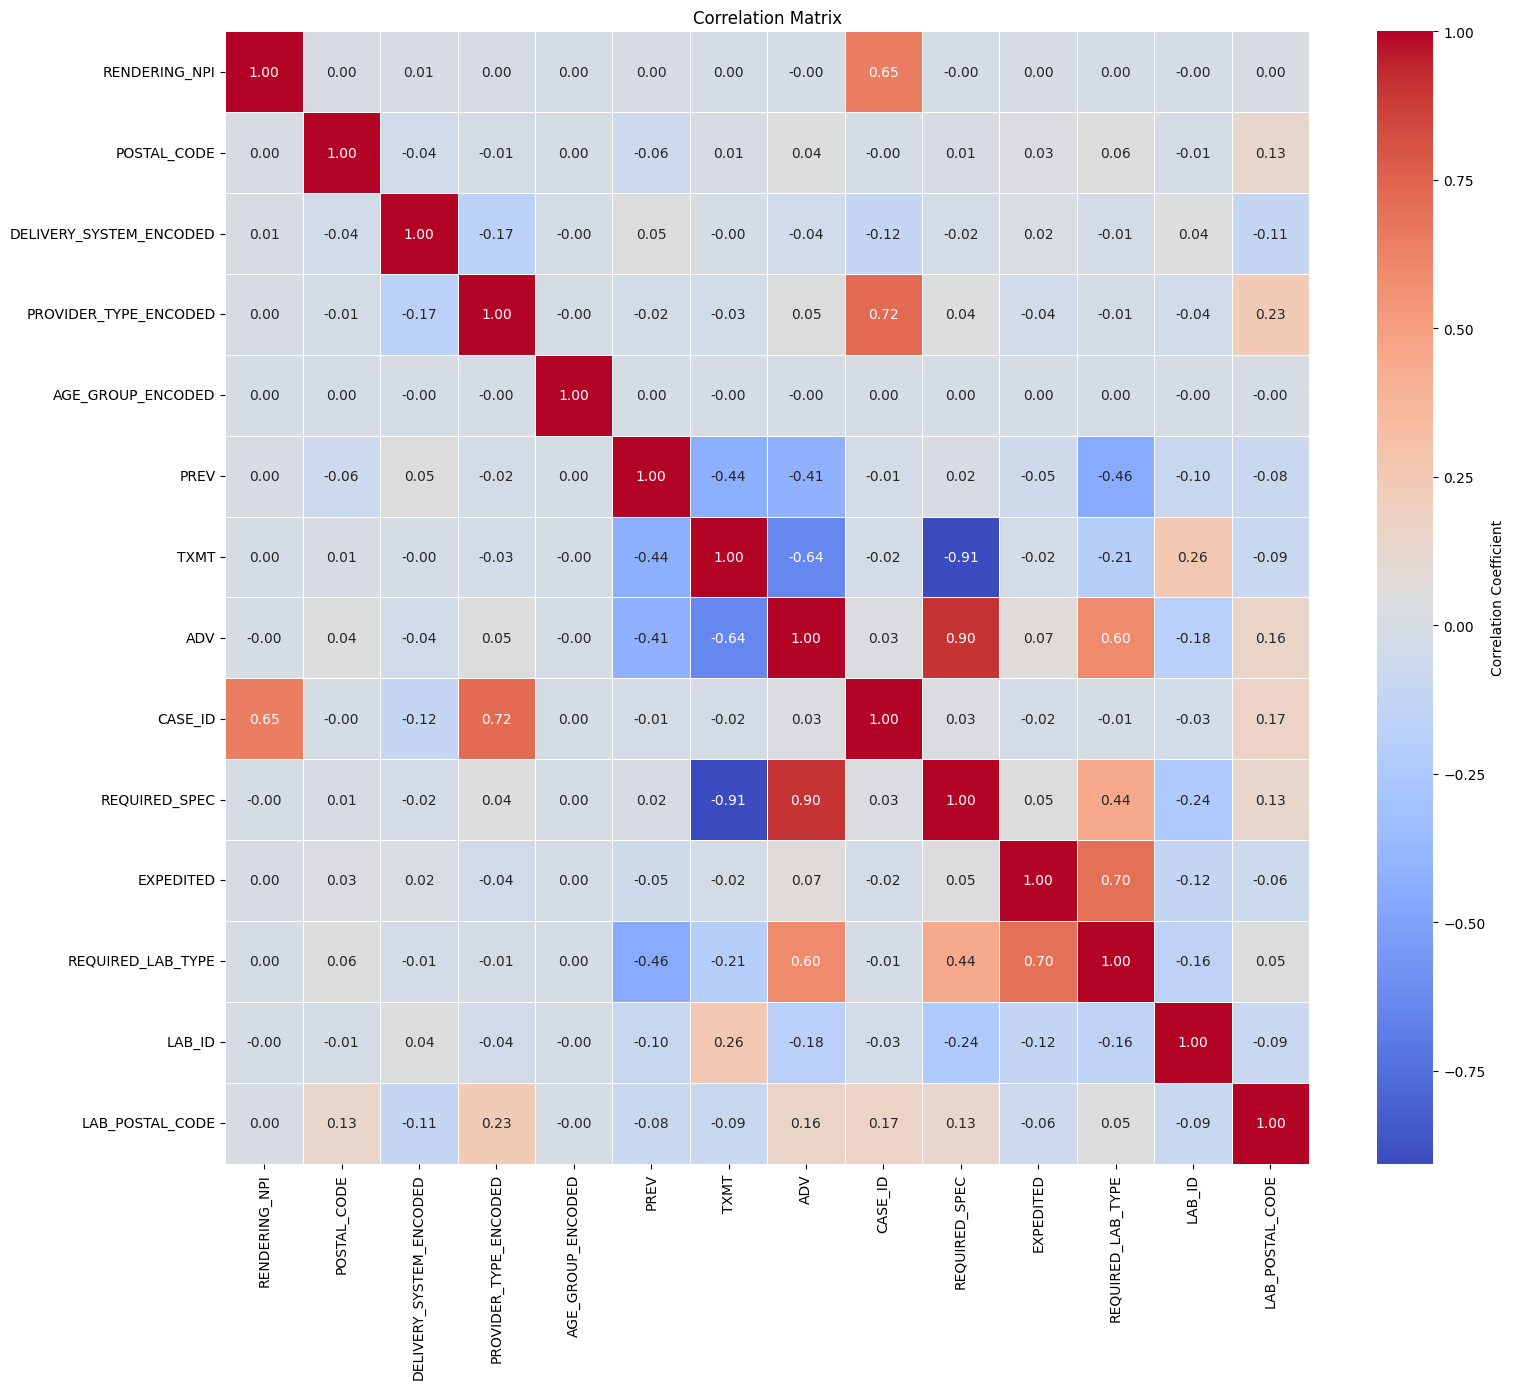

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_filtered.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()
plt.close()

In [55]:
df_filtered['LAB_POSTAL_3'] = np.int64(df_filtered['LAB_POSTAL_CODE'].astype(str).str[:4])
df_filtered.head(1)

,RENDERING_NPI,POSTAL_CODE,DELIVERY_SYSTEM_ENCODED,PROVIDER_TYPE_ENCODED,AGE_GROUP_ENCODED,PREV,TXMT,ADV,CASE_ID,REQUIRED_SPEC,EXPEDITED,REQUIRED_LAB_TYPE,LAB_ID,LAB_POSTAL_CODE,LAB_POSTAL_3
1,1669575783,94601,0,1,0,0,1,0,1673754,0,1,2,305,94420,9442


In [40]:
df_filtered.isnull().sum()

,0
RENDERING_NPI,0
POSTAL_CODE,0
DELIVERY_SYSTEM_ENCODED,0
PROVIDER_TYPE_ENCODED,0
AGE_GROUP_ENCODED,0
PREV,0
TXMT,0
ADV,0
CASE_ID,0
REQUIRED_SPEC,0


In [56]:
#@title XGBoost Pre-Processing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

df_main = df_filtered.copy()

TARGET_COLUMN = 'LAB_ID'

EXCLUDE_COLUMNS = [
    'RENDERING_NPI',
    'CASE_ID',
    TARGET_COLUMN,
    'LAB_POSTAL_CODE',
]

features = [col for col in df_main.columns if col not in EXCLUDE_COLUMNS]

X = df_main[features].copy()
y = df_main[TARGET_COLUMN].copy()

postal_encoder = LabelEncoder()
X['POSTAL_CODE_ENCODED'] = postal_encoder.fit_transform(X['POSTAL_CODE'].astype(str))
X.drop(columns=['POSTAL_CODE'], inplace=True)

lab_3_digit_encoder = LabelEncoder()
X['LAB_POSTAL_3_ENCODED'] = lab_3_digit_encoder.fit_transform(X['LAB_POSTAL_3'])
X.drop(columns=['LAB_POSTAL_3'], inplace=True)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
n_classes_train = len(label_encoder.classes_)

non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns
X.drop(columns=non_numeric_cols, inplace=True, errors='ignore')

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42
)


In [57]:
#@title XGBoost Classification: >90% Accuracy
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=n_classes_train,
    n_estimators=100,
    learning_rate=0.1,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,

    tree_method='gpu_hist'
)

print(f"\nsamples: {len(X_train):,} \nunique LAB_IDs: {n_classes_train}")
xgb_model.fit(X_train, y_train_encoded)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")


samples: 471,348 
unique LAB_IDs: 119


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:50:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:50:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [22:50:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:



Model Accuracy: 0.9386
